In [3]:
import pandas as pd
import os
import time
from datetime import datetime

from time import mktime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import re
%matplotlib inline
style.use("dark_background")

In [4]:
path = 'intraQuarter/'

In [5]:
def Key_Stats(gather = 'Total Debt/Equity (mrq)'):
    statspath = path + '_KeyStats'
    stock_list = [x[0] for x in os.walk(statspath)]
    df = pd.DataFrame(columns=["Date", 
                               "Unix", 
                               "Ticker", 
                               "DE Ratio", 
                               "Price", 
                               "stock_p_change", 
                               "SP500", 
                               "sp500_p_change",
                               "Difference",
                               "Status"])
    
    sp500_df = pd.DataFrame.from_csv("YAHOO-INDEX_GSPC.csv")
    ticker_list = []
    
    for each_dir in stock_list[1:25]:
        each_file = os.listdir(each_dir)
        ticker = each_dir.split('/')[-1]
        ticker_list.append(ticker)
        
        starting_stock_value = False
        starting_sp500_value = False
        
        if len(each_file) > 0:
            for file in each_file:
                if file != ".DS_Store":
                    date_stamp = datetime.strptime(file, '%Y%m%d%H%M%S.html')
                    #print date_stamp
                    unix_time = time.mktime(date_stamp.timetuple())
                    #print date_stamp, unix_time
                    
                    full_file_path = each_dir + "/" + file
                    #print full_file_path
                    source = open(full_file_path, "r").read()
                    
                    try:
                        try:
                            value = float(source.split(gather+':</td><td class="yfnc_tabledata1">')[1].split('</td>')[0])
                        except Exception as e:
                            value = float(source.split(gather+':</td>\n<td class="yfnc_tabledata1">')[1].split('</td>')[0])
                            print "Error is ", str(e), ticker, file
                            #time.sleep(1)
                        
                        try:
                            sp500_date = datetime.fromtimestamp(unix_time).strftime("%Y-%m-%d")
                            row = sp500_df[(sp500_df.index == sp500_date)]
                            sp500_value = float(row["Adj Close"])
                        except:
                            sp500_date = datetime.fromtimestamp(unix_time - 259200).strftime("%Y-%m-%d")
                            row = sp500_df[(sp500_df.index == sp500_date)]
                            sp500_value = float(row["Adj Close"])
                        
                        try:
                            stock_price = float(source.split("</small><big><b>")[1].split("</b></big>")[0])
                        except Exception as e:
                            #print e
                            try:
                                stock_price = source.split("</small><big><b>")[1].split("</b></big>")[0]
                                stock_price = re.search(r'(\d{1,8}\.\d{1,8})', stock_price)
                                stock_price = float(stock_price.group(0))
                                #print stock_price
                            except Exception as e:
                                stock_price = source.split('<span class="time_rtq_ticker">')[1].split("</span>")[0]
                                stock_price = re.search(r'(\d{1,8}\.\d{1,8})', stock_price)
                                stock_price = float(stock_price.group(0))
                                #print stock_price
                                #print str(e)
                                #time.sleep(1)
                        
                        if not starting_stock_value:
                            starting_stock_value = stock_price
                        if not starting_sp500_value:
                            starting_sp500_value = sp500_value
                                                
                        stock_p_change = ((stock_price - starting_stock_value) / starting_stock_value) * 100
                        sp500_p_change = ((sp500_value - starting_sp500_value) / starting_sp500_value) * 100
                                                
                        
                        difference = stock_p_change-sp500_p_change
                        if difference > 0:
                            status = "outperform"
                        else:
                            status = "underperform"
                        
                        df = df.append({"Date":date_stamp, 
                                        "Unix":unix_time, 
                                        "Ticker":ticker, 
                                        "DE Ratio":value, 
                                        "Price":stock_price,
                                        "stock_p_change": stock_p_change,
                                        "SP500":sp500_value,
                                        "sp500_p_change": sp500_p_change, 
                                        "Difference": difference,
                                        "Status": status,
                                       }, ignore_index=True)
                
                    except Exception as e:
                        #print str(e), ticker, file
                        pass
                    #time.sleep(5)
    
    for each_ticker in ticker_list:
        try:
            plot_df = df[(df["Ticker"] == each_ticker)]
            plot_df = plot_df.set_index(["Date"])
            
            if plot_df['Status'][-1] == 'underperform':
                color = 'r'
            else:
                color = 'g'
            
            plot_df['Difference'].plot(label = each_ticker, color=color)
            plt.legend()
        except:
            pass
    
    plt.show()
    
    save = gather.replace(" ", "").replace("(", "").replace(")", "").replace("/", "")+(".csv")
    print save
    df.to_csv(save)

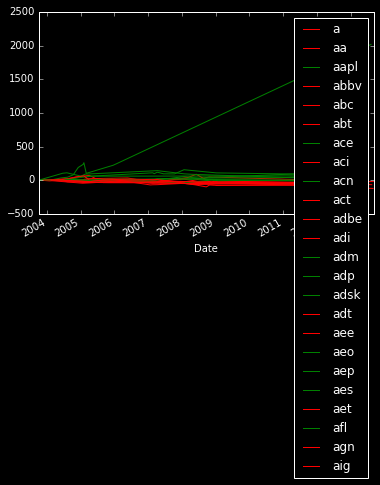

TotalDebtEquitymrq.csv


In [6]:
Key_Stats()